In [2]:
# Dependencies and setup
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as st
import requests
import json
import gmaps
import os

from api_keys import g_key

# Files to load
rent_data_load = "Apartment_List_Rent_Data_-_City_2020-7.csv"
home_value_load = "RDC_Inventory_Core_Metrics_Zip.csv"
home_value_history_load = "RDC_Inventory_Core_Metrics_Zip_History.csv"
state_abbrev_load = "State_Abbrev.csv"

# Read files into dataframe
rent_df = pd.read_csv(rent_data_load)
home_value_df = pd.read_csv(home_value_load) 
state_abbrev_df = pd.read_csv(state_abbrev_load) 

# Average Studio, 1, 2, 3, 4 bedroom
rent_ave = rent_df.groupby(["City_State"]).mean()

# Average home value of zip codes in city
home_value_ave = home_value_df.groupby(["City_State"]).mean()

# Merge files
rent_value_merge = pd.merge(rent_ave,home_value_ave, how="left",left_index=True,right_index=True)
rent_value_merge["June2020_Rent/Price"] = rent_value_merge['Price_2020_06']/rent_value_merge["average_listing_price"]
rent_value_merge.head()

,Price_2014_01,Price_2014_02,Price_2014_03,Price_2014_04,Price_2014_05,Price_2014_06,Price_2014_07,Price_2014_08,Price_2014_09,Price_2014_10,...,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy,June2020_Rent/Price
City_State,,,,,,,,,,,,,,,,,,,,,
Aberdeen_MD,1137.6,1131.2,1126.6,1131.6,1136.4,1149.6,1151.8,1159.8,1163.4,1168.8,...,306960.0,0.05090,0.04660,54.0,0.05880,-0.48570,0.14890,0.0402,0.04370,0.004042
Abilene_TX,867.4,871.6,873.2,876.6,878.8,881.6,881.0,882.4,883.6,886.2,...,246723.0,0.05478,0.09536,142.0,0.11084,0.05668,1.18362,0.3465,0.43876,0.003803
Acworth_GA,1091.8,1100.2,1102.2,1104.2,1111.6,1114.4,1125.4,1130.6,1130.0,1131.0,...,416096.0,0.03405,0.11365,522.0,0.05625,-0.14260,1.43110,0.5209,0.66925,0.002905
Addison_TX,1206.0,1211.4,1213.4,1223.2,1228.0,1232.6,1229.2,1233.6,1243.4,1256.2,...,360374.0,0.00860,-0.01290,49.0,0.06520,0.06520,0.68970,0.1034,-0.22700,0.003748
Adelanto_CA,1106.4,1100.6,1104.8,1103.2,1109.2,1124.8,1141.6,1149.2,1146.6,1144.0,...,251783.0,-0.00090,0.03450,121.0,-0.11030,-0.28820,2.36110,0.5278,1.40710,0.005699


In [3]:
rent_value_merge["1% Flag"] = rent_value_merge[rent_value_merge["June2020_Rent/Price"]>=.01]["June2020_Rent/Price"]
rent_value_merge["1% Flag"].count()

5

In [4]:
# Removes null values and only keeps rent and listin price
rent_value_merge_drop = rent_value_merge[['Price_2020_06','average_listing_price']].dropna()
rent_value_merge_drop.head()

,Price_2020_06,average_listing_price
City_State,,
Aberdeen_MD,1240.8,306960.0
Abilene_TX,938.4,246723.0
Acworth_GA,1208.6,416096.0
Addison_TX,1350.6,360374.0
Adelanto_CA,1434.8,251783.0


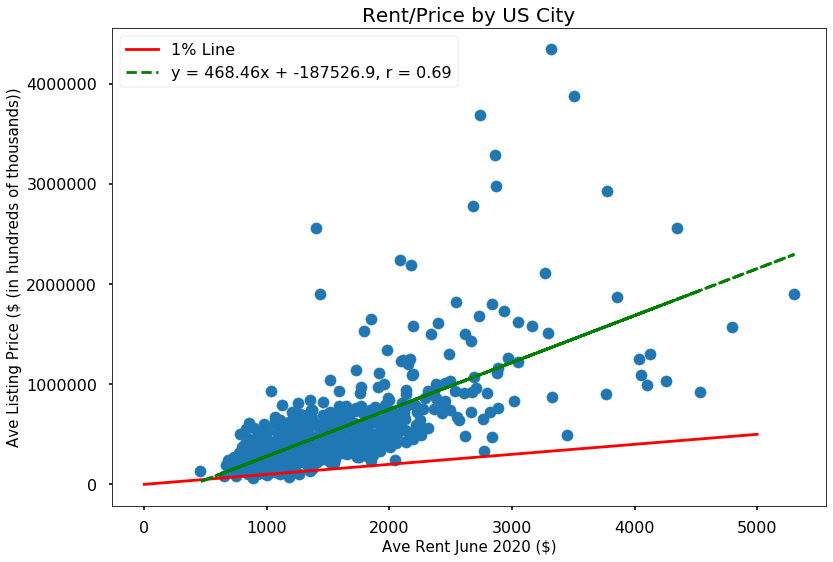

In [6]:
plt.scatter(rent_value_merge['Price_2020_06'],rent_value_merge['average_listing_price'])
plt.ylabel("Ave Listing Price ($ (in hundreds of thousands))", fontsize=15)
plt.xlabel("Ave Rent June 2020 ($)", fontsize=15)
plt.title("Rent/Price by US City", fontsize=20)
plt.style.use('seaborn-poster')
# 1% line, below are prospective
plt.plot([0,5000],[0,500000],"r", Label="1% Line")
plt.legend()

# trendline(rent_value_merge['Price_2020_06'],rent_value_merge['average_listing_price'])


slope, inter, r, p, std_err = st.linregress(rent_value_merge_drop['Price_2020_06'],rent_value_merge_drop['average_listing_price'])
fit = slope * rent_value_merge['Price_2020_06'] + inter
plt.plot(rent_value_merge['Price_2020_06'],fit,"--g",label="y = "+ str(round(slope,2)) + "x + "+ str(round(inter,1))+', r = ' + str(round(r,2)))
plt.legend()
plt.rcParams["figure.figsize"] = (25,20)

In [8]:
# List of cities to analyze further
prospective_cities = pd.DataFrame(rent_value_merge["1% Flag"].dropna())
prospective_cities

,1% Flag
City_State,
Calumet City_IL,0.010897
Camden_NJ,0.015162
Gary_IN,0.010710
Inkster_MI,0.013263
Park Forest_IL,0.012616


Text(0.5, 0, 'Cities and States')

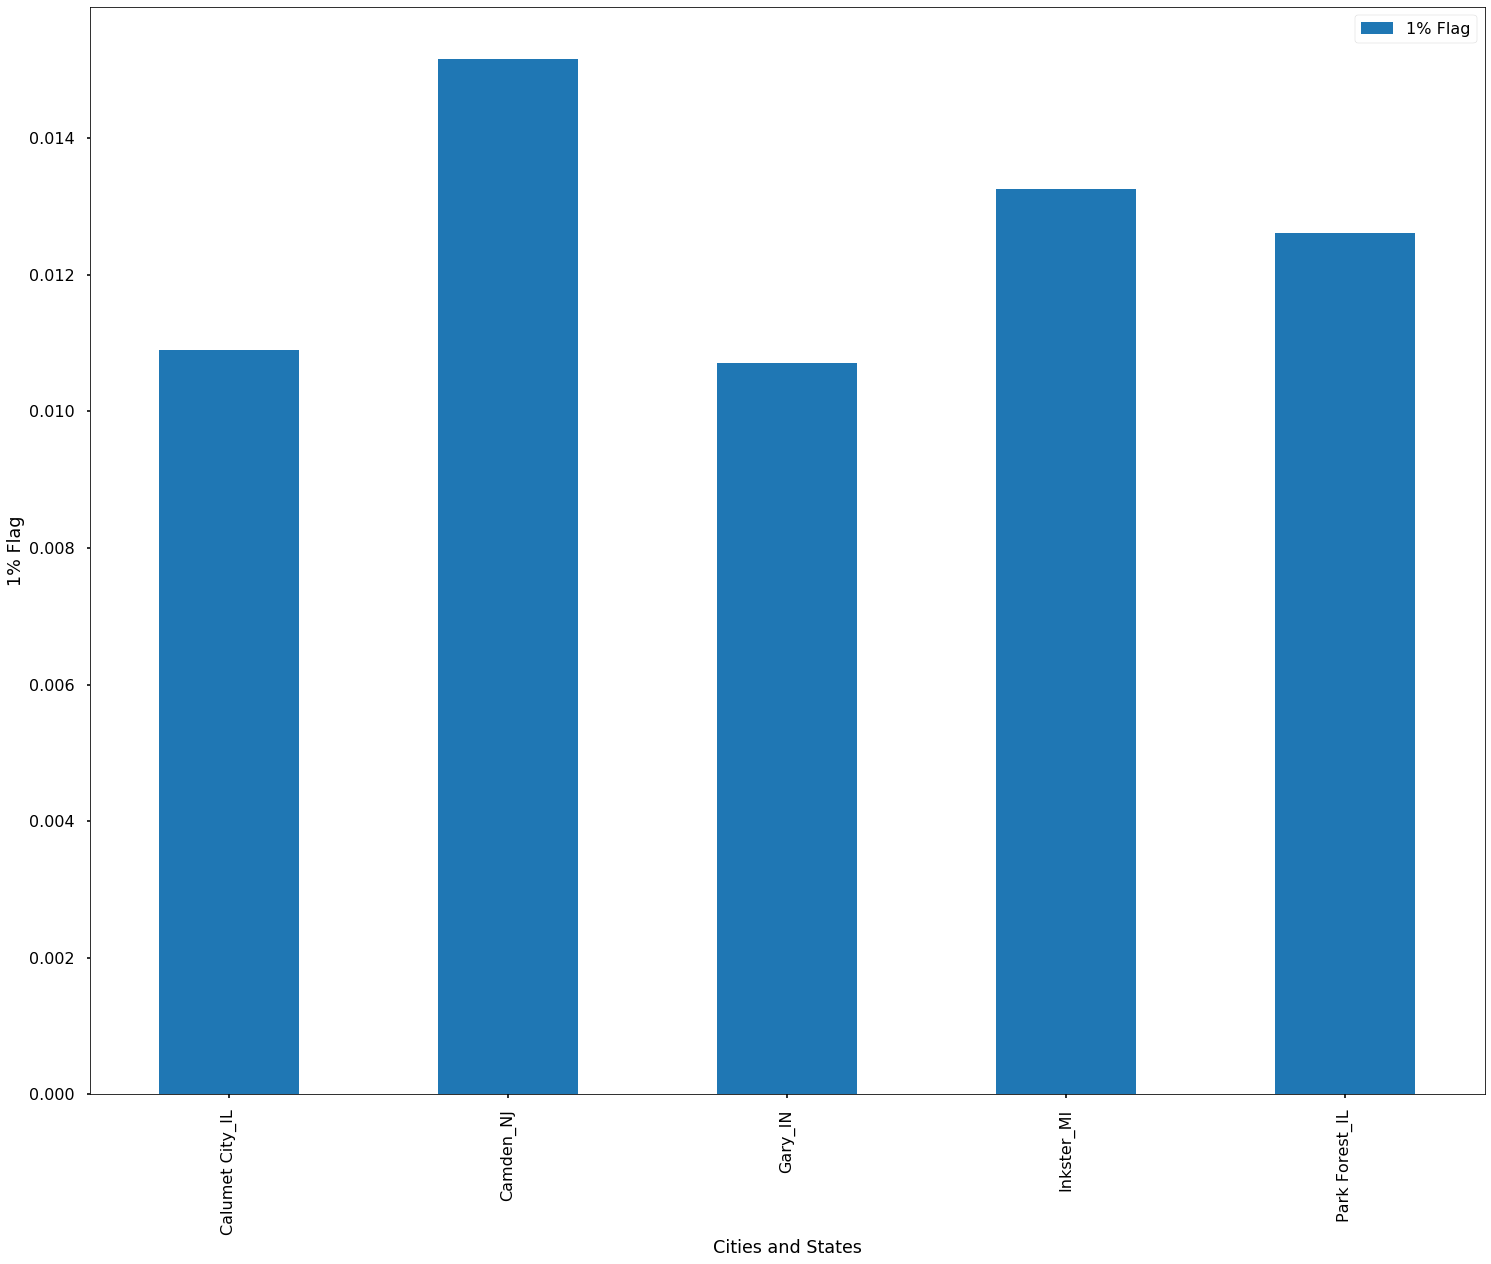

In [9]:
# Plots rent/value for cities over 1%
prospective_cities.plot.bar()
plt.ylabel("1% Flag")
plt.xlabel("Cities and States")

In [11]:
# Creates series for each prospective city of rent vs. time
rent_prospective_merge = pd.merge(prospective_cities,rent_ave, how="left",left_index=True,right_index=True).drop(["1% Flag"],axis=1)
cal_row = rent_prospective_merge.iloc[0]
cam_row = rent_prospective_merge.iloc[1]
gary_row = rent_prospective_merge.iloc[2]
ink_row = rent_prospective_merge.iloc[3]
park_row = rent_prospective_merge.iloc[4]
labels = cal_row.index

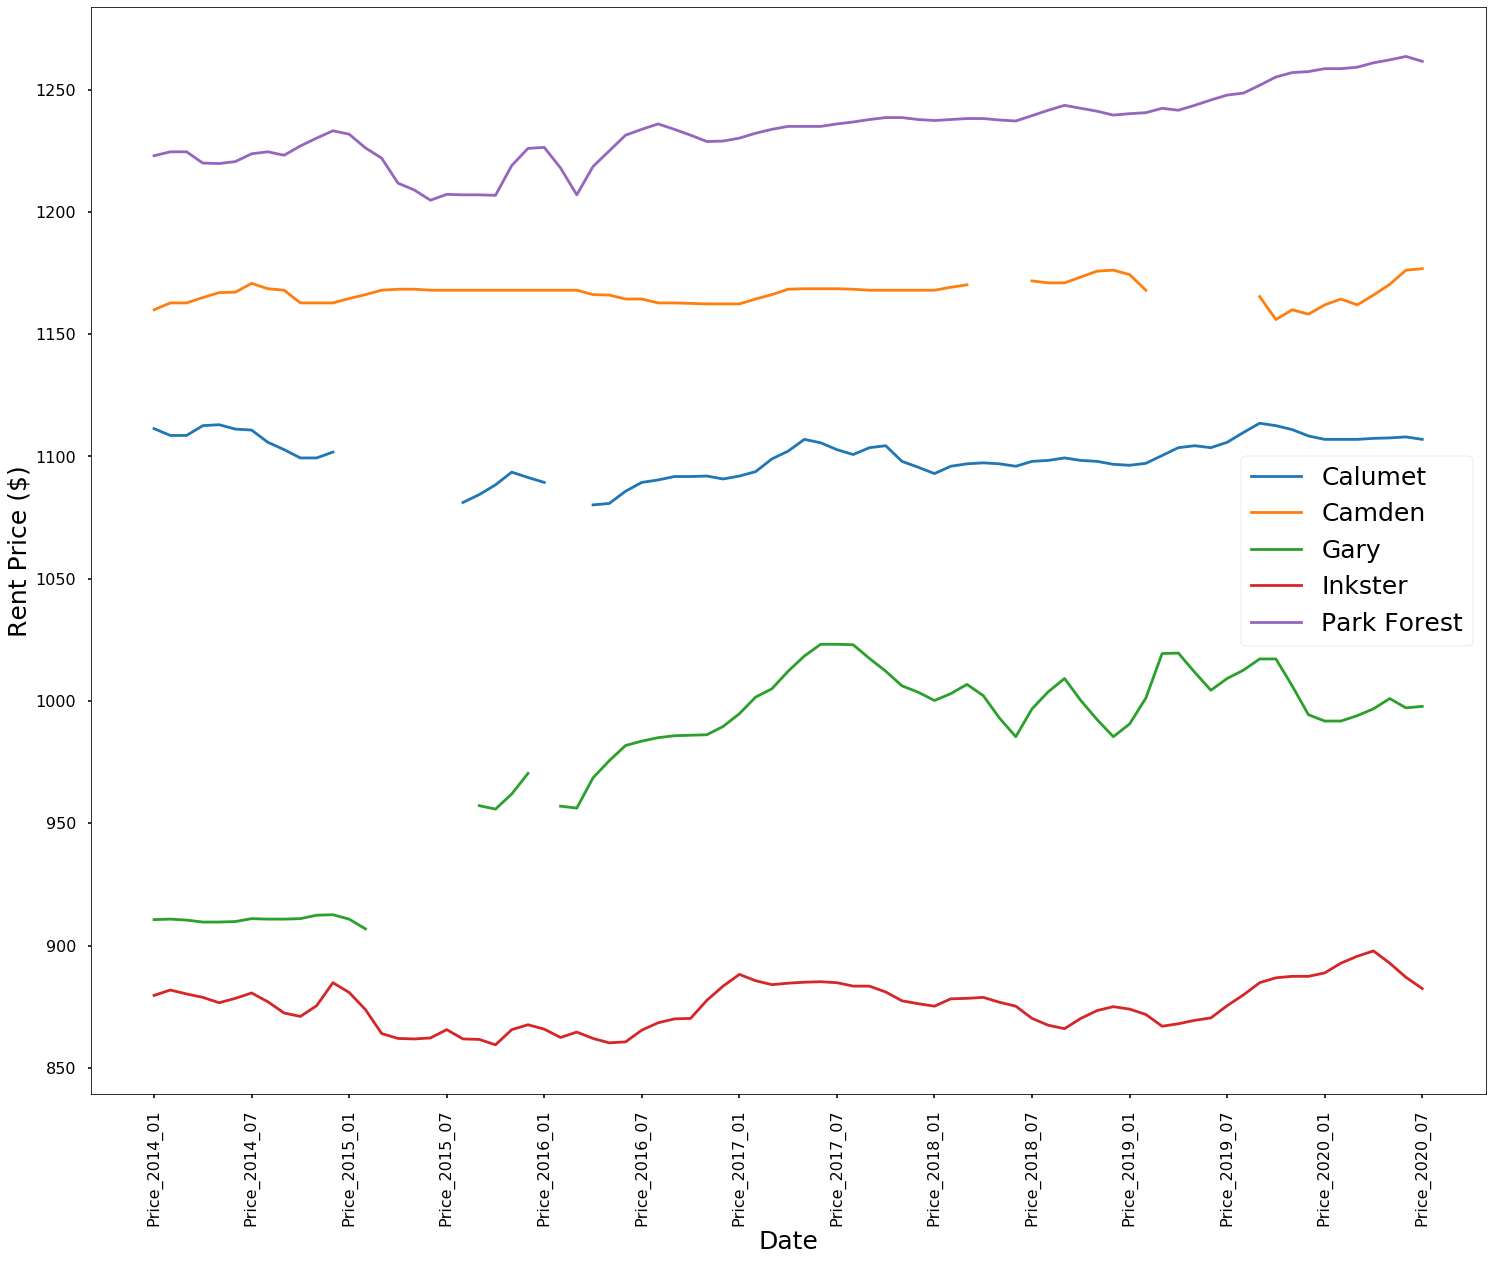

In [12]:
# Plots rent vs. time for each prospective city
plt.plot(cal_row, label="Calumet")
plt.plot(cam_row,label="Camden")
plt.plot(gary_row, label="Gary")
plt.plot(ink_row, label = "Inkster")
plt.plot(park_row, label="Park Forest")
plt.xticks(labels[::6],rotation=90)
plt.legend(fontsize=25)
plt.ylabel("Rent Price ($)",fontsize=25)
plt.xlabel("Date",fontsize=25)
# plt.set_size_inches(18.5, 10.5)
# plt.figsize(20,20)
plt.rcParams["figure.figsize"] = (25,20)

In [13]:
# Adds date to the listing price
home_value_history_df = pd.read_csv(home_value_history_load)
home_value_history_prospective = pd.merge(prospective_cities,home_value_history_df, how="left",left_index=True,right_on="City_State")
home_value_history_prospective=home_value_history_prospective.sort_values(['month_date_yyyymm'])
home_value_history_prospective

C:\Users\chris\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (0,4,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,1% Flag,Unnamed: 0,Unnamed: 1,month_date_yyyymm,month_year,postal_code,zip_name,flag,City,City_State,...,median_square_feet_yy,average_listing_price,average_listing_price_mm,average_listing_price_yy,total_listing_count,total_listing_count_mm,total_listing_count_yy,pending_ratio,pending_ratio_mm,pending_ratio_yy
749261,0.012616,2016,7.0,201607.0,7/2016,60466,"park forest, il",NaN,Park Forest,Park Forest_IL,...,NaN,61987.0,NaN,NaN,241.0,NaN,NaN,0.6395,NaN,NaN
751908,0.013263,2016,7.0,201607.0,7/2016,48141,"inkster, mi",NaN,Inkster,Inkster_MI,...,NaN,33140.0,NaN,NaN,126.0,NaN,NaN,0.0080,NaN,NaN
760287,0.010710,2016,7.0,201607.0,7/2016,46407,"gary, in",NaN,Gary,Gary_IN,...,NaN,30910.0,NaN,NaN,19.0,NaN,NaN,0.0000,NaN,NaN
759030,0.010710,2016,7.0,201607.0,7/2016,46403,"gary, in",NaN,Gary,Gary_IN,...,NaN,165766.0,NaN,NaN,58.0,NaN,NaN,0.1154,NaN,NaN
753673,0.010710,2016,7.0,201607.0,7/2016,46406,"gary, in",NaN,Gary,Gary_IN,...,NaN,33370.0,NaN,NaN,20.0,NaN,NaN,0.0000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3584,0.015162,2020,6.0,202006.0,6/2020,8105,"camden, nj",NaN,Camden,Camden_NJ,...,-0.0447,88393.0,0.0799,0.0120,27.0,-0.0690,-0.3250,0.0385,0.0385,-0.0726
8533,0.015162,2020,6.0,202006.0,6/2020,8103,"camden, nj",*,Camden,Camden_NJ,...,0.0394,87477.0,0.0922,0.0449,19.0,0.1176,-0.3448,0.0000,0.0000,-0.0357
8914,0.015162,2020,6.0,202006.0,6/2020,8104,"camden, nj",NaN,Camden,Camden_NJ,...,-0.0061,56861.0,0.0100,-0.0217,46.0,0.0455,-0.2923,0.0222,-0.0010,-0.0095
4493,0.012616,2020,6.0,202006.0,6/2020,60466,"park forest, il",NaN,Park Forest,Park Forest_IL,...,-0.0942,100155.0,0.0276,0.2451,163.0,-0.0468,0.0062,0.8736,0.2450,0.2372


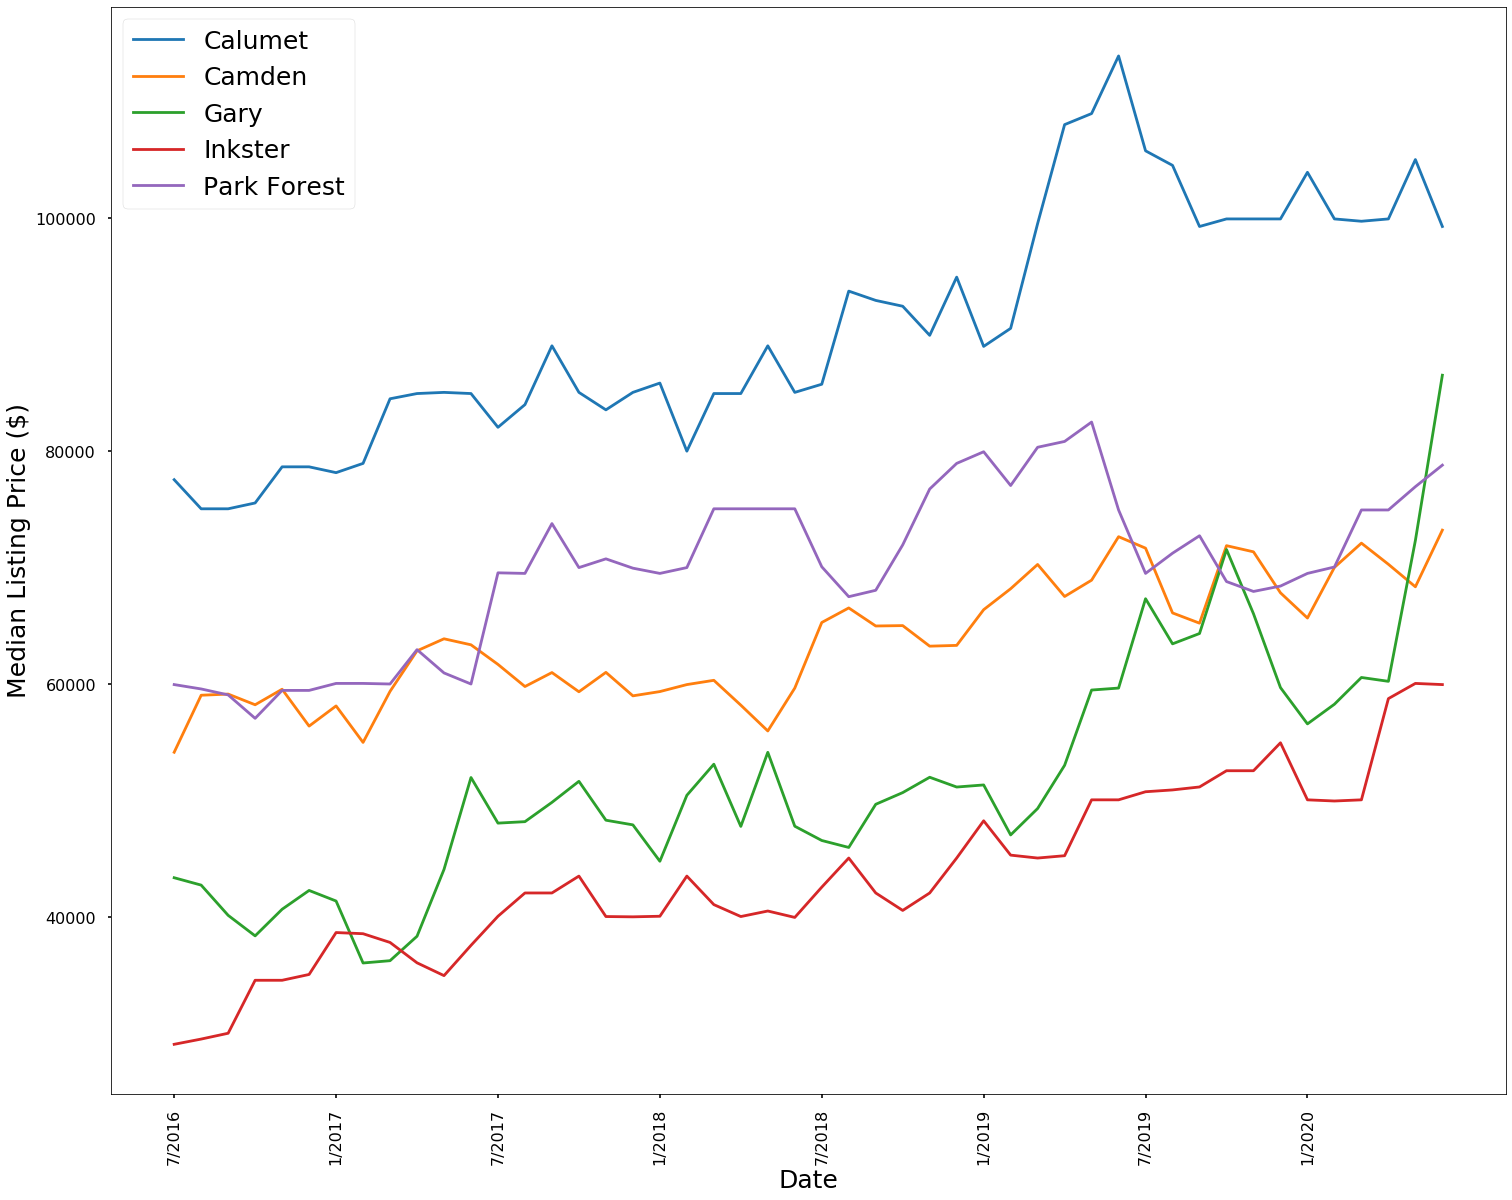

In [16]:
# Creates dataframes for prospective cities and plots
cal_df = home_value_history_prospective[home_value_history_prospective["City_State"]=="Calumet City_IL"]
cam_df = home_value_history_prospective[home_value_history_prospective["City_State"]=="Camden_NJ"].groupby(["month_year"]).mean().sort_values(['month_date_yyyymm'])
gary_df = home_value_history_prospective[home_value_history_prospective["City_State"]=="Gary_IN"].groupby(["month_year"]).mean().sort_values(['month_date_yyyymm'])
ink_df = home_value_history_prospective[home_value_history_prospective["City_State"]=="Inkster_MI"]
park_df = home_value_history_prospective[home_value_history_prospective["City_State"]=="Park Forest_IL"]

plt.plot(cal_df["month_year"], cal_df['median_listing_price'],label="Calumet")
plt.plot(cam_df['median_listing_price'],label="Camden")
plt.plot(gary_df['median_listing_price'], label="Gary")
plt.plot(ink_df["month_year"], ink_df['median_listing_price'], label = "Inkster")
plt.plot(park_df["month_year"], park_df['median_listing_price'], label="Park Forest")
plt.xticks(cal_df["month_year"][::6],rotation=90)
plt.legend(fontsize=25)
plt.ylabel("Median Listing Price ($)",fontsize=25)
plt.xlabel("Date",fontsize=25)
# plt.set_size_inches(18.5, 10.5)
# plt.figsize(20,20)
plt.rcParams["figure.figsize"] = (25,20)


In [162]:
#  splits city and state into seperate columns
rent_value_merge_drop.reset_index(inplace=True)
rent_value_merge_drop[["City","State"]] = rent_value_merge_drop.City_State.str.split('_',expand=True)
rent_value_merge_drop.head()

,City_State,Price_2020_06,average_listing_price,City,State
0,Aberdeen_MD,1240.8,306960.0,Aberdeen,MD
1,Abilene_TX,938.4,246723.0,Abilene,TX
2,Acworth_GA,1208.6,416096.0,Acworth,GA
3,Addison_TX,1350.6,360374.0,Addison,TX
4,Adelanto_CA,1434.8,251783.0,Adelanto,CA


In [183]:
# merges with state abbreviation csv to add full state name
rent_value_merge_drop_state = pd.merge(rent_value_merge_drop,state_abbrev_df,how='left',left_on="State",right_on="State")
rent_value_merge_drop_state.head()


,City_State,Price_2020_06,average_listing_price,City,State,State_Name
0,Aberdeen_MD,1240.8,306960.0,Aberdeen,MD,Maryland
1,Abilene_TX,938.4,246723.0,Abilene,TX,Texas
2,Acworth_GA,1208.6,416096.0,Acworth,GA,Georgia
3,Addison_TX,1350.6,360374.0,Addison,TX,Texas
4,Adelanto_CA,1434.8,251783.0,Adelanto,CA,California


In [211]:
# Adds Lat Lng to the data frame 
params = {"key": g_key}
for index, row in rent_value_merge_drop_state.iterrows():
    base_url = 'https://maps.googleapis.com/maps/api/geocode/json'
    city = row['City']
    state=row['State_Name']
    params['address']=f"{city},{state}"
    
    cities_lat_lng = requests.get(base_url,params=params)
    cities_lat_lng = cities_lat_lng.json()
    
    try:
        rent_value_merge_drop_state.loc[index, "Lat"] = cities_lat_lng["results"][0]["geometry"]["location"]["lat"]
        rent_value_merge_drop_state.loc[index, "Lng"] = cities_lat_lng["results"][0]["geometry"]["location"]["lng"]
        print
    except (KeyError, IndexError):
        print("Missing field/result... skipping.")
        
rent_value_merge_drop_state.head()

,City_State,Price_2020_06,average_listing_price,City,State,State_Name,Lat,Lng
0,Aberdeen_MD,1240.8,306960.0,Aberdeen,MD,Maryland,39.509556,-76.164120
1,Abilene_TX,938.4,246723.0,Abilene,TX,Texas,32.448736,-99.733144
2,Acworth_GA,1208.6,416096.0,Acworth,GA,Georgia,34.065933,-84.676880
3,Addison_TX,1350.6,360374.0,Addison,TX,Texas,32.961790,-96.829169
4,Adelanto_CA,1434.8,251783.0,Adelanto,CA,California,34.582770,-117.409215


In [195]:
gmaps.configure(api_key=g_key)

In [240]:
# Creates heat map of June 2020 rent/listing price for all cities
locations = rent_value_merge_drop_state[["Lat", "Lng"]].astype(float)
rent_value_merge_drop_state["rent/price"] = 100*rent_value_merge_drop_state["Price_2020_06"]/rent_value_merge_drop_state["average_listing_price"]
rent_value = rent_value_merge_drop_state["rent/price"].astype(float)
fig = gmaps.figure()
# heat_layer = gmaps.heatmap_layer(locations, weights=humidity, dissipating=False, max_intensity=100, point_radius = 1)
heat_layer = gmaps.heatmap_layer(locations, weights=rent_value, max_intensity=7, point_radius = 10)

fig.add_layer(heat_layer)
fig

Figure(layout=FigureLayout(height='420px'))

In [239]:
# Creates csv of for June with Lat Lngs
rent_value_merge_drop_state.to_csv("June_2020_Rent_Value.csv")